In [1]:
import sqlite3
import pandas as pd
import numpy as np
import os
import geopandas as gpd
import rasterio as rio
from rasterio.plot import show
from rasterio.mask import mask
from scripts.scripts import *
import matplotlib.pyplot as plt
import geosardine as dine
import sklearn
from affine import Affine
import xarray
#quick viz of it all!
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io.img_tiles import Stamen
import matplotlib.patches as mpatches

# 1. VALIDATION EXPERIMENT ANALYSIS

In [2]:
#Open the data from the excel sheet

turb = pd.read_excel(os.path.join(os.getcwd(),"data","a3_experiments_2404.xlsx"), engine = "openpyxl",sheet_name  = "TURB")
tds = pd.read_excel(os.path.join(os.getcwd(),"data","a3_experiments_2404.xlsx"), engine = "openpyxl",sheet_name  = "TDS")
ph = pd.read_excel(os.path.join(os.getcwd(),"data","a3_experiments_2404.xlsx"), engine = "openpyxl",sheet_name  = "PH")
temp =  pd.read_excel(os.path.join(os.getcwd(),"data","a3_experiments_2404.xlsx"), engine = "openpyxl",sheet_name  = "TEMP")

In [3]:
# Calibrate the data into usable values, from the calibrated solutions
def calibrate(hi,lo,vhi,vlo, obs):
    m = (hi-lo)/(vhi-vlo)
    val = hi-(vhi-obs)*m
    return val

#For turbidity, rinse and repeat for allthe other ones
t_hi = turb.Meter[3]
t_lo = turb.Meter[0]
tv_hi = turb.Robot[3]
tv_lo = turb.Robot[0]
cal = calibrate(hi = t_hi, lo = t_lo,vhi = tv_hi, vlo = tv_lo, obs = turb.Robot)
turb["Calib"] = cal

# for tds
t_hi = tds.Meter[0]
t_lo = tds.Meter[3]
tv_hi = tds.Robot[0]
tv_lo = tds.Robot[3]
cal = calibrate(hi = t_hi, lo = t_lo,vhi = tv_hi, vlo = tv_lo, obs = tds.Robot)
tds["Calib"] = cal

# for pH
t_hi = ph.Meter[1]
t_lo = ph.Meter[0]
tv_hi = ph.Robot[1]
tv_lo = ph.Robot[0]
cal = calibrate(hi = t_hi, lo = t_lo,vhi = tv_hi, vlo = tv_lo, obs = ph.Robot)
ph["Calib"] = cal



Make a figure from this data, in order to quickly show off the results

<ipython-input-10-3dd382696cd1>:64: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


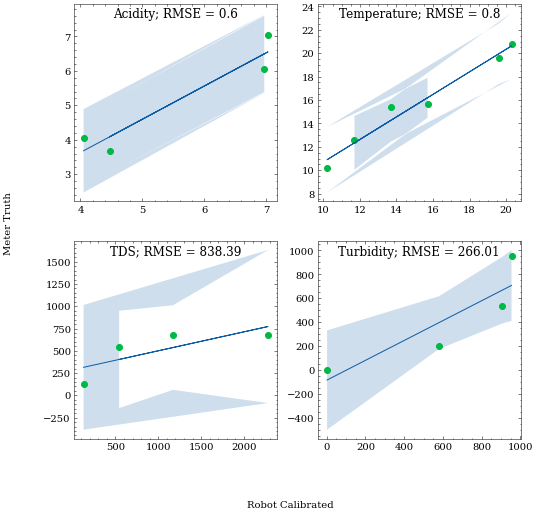

In [10]:
def error_data(x,y):
    import numpy as np
    a, b = np.polyfit(x, y, deg=1)
    y_est = a * x + b
    y_err = x.std() * np.sqrt(1/len(x) +
                              (x - x.mean())**2 / np.sum((x - x.mean())**2))
    
    from sklearn.metrics import mean_squared_error

    rms = mean_squared_error(x, y, squared=False)

    return y_est, y_err,rms

import matplotlib.pyplot as plt


%matplotlib inline

plt.style.use(['science','no-latex'])
fig, axs = plt.subplots(nrows = 2, ncols =2,figsize = (8,8))

x = ph.Meter
y= ph.Calib
y_est, y_err,rms = error_data(x,y)
axs[0,0].plot(x, y_est, '-')
axs[0,0].fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
axs[0,0].scatter( ph.Meter, ph.Calib)
axs[0,0].set_title(f"Acidity; RMSE = {round(rms,2)}" , y=1.0, pad=-14)



x =temp.Meter
y= temp.Robot
y_est, y_err,rms = error_data(x,y)
axs[0,1].plot(x, y_est, '-')
axs[0,1].fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
axs[0,1].scatter( temp.Meter, temp.Robot)
axs[0,1].set_title(f"Temperature; RMSE = {round(rms,2)}", y=1.0, pad=-14)



x = tds.Meter
y= tds.Calib
y_est, y_err,rms = error_data(x,y)
axs[1,0].plot(x, y_est, '-')
axs[1,0].fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
axs[1,0].scatter( tds.Meter, tds.Calib)
axs[1,0].set_title(f"TDS; RMSE = {round(rms,2)}", y=1.0, pad=-14)



x = turb.Meter
y= turb.Calib
y_est, y_err,rms = error_data(x,y)
axs[1,1].plot(x, y_est, '-')
axs[1,1].fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
axs[1,1].scatter( turb.Meter, turb.Calib)
axs[1,1].set_title(f"Turbidity; RMSE = {round(rms,2)}", y=1.0, pad=-14)

fig.text(0.5, 0.01, 'Robot Calibrated', va='center', ha='center', fontsize=plt.rcParams['axes.labelsize'])
fig.text(0.01, 0.5, 'Meter Truth', va='center', ha='center', rotation='vertical', fontsize=plt.rcParams['axes.labelsize'])

fig.savefig("output/calibration_results.png", dpi=300)
fig.show()


# 2. MAPPING

## 2.1. Interpolation data preparation
From raw ROS2 bags, to usable pandas dataframes

In [2]:
from scripts.scripts import *

def load_rosbag(rosbagname):
    import pandas as pd
    import numpy as np
    import geopandas as gpd
    import sqlite3
    import os

 
    # the bags are found in this zip under data
    # directory should point to that

    db_loc = os.path.join(os.path.expanduser('~'), "Documents","wqdrone","rosbags",rosbagname,rosbagname+"_0.db3")

    #create connection to rosbag
    con = sqlite3.connect(db_loc)

    #read the topics in the rosbag
    topics = pd.read_sql("SELECT * from topics", con)
    # read all the msgs in the rosbag
    msgs = pd.read_sql("SELECT * from messages", con)

    #/topics that you want
    t1 = "teensy_fix" 
    t2 =  "wq_sensors"

    #the above function is called to create df out of the rosbag
    df_fix = parse_df(topics,msgs, t1,gps_float64,cols = ["lat", "lon","alt"])
    df_wq = parse_df(topics,msgs, t2, wq_float64,cols = ["temp","tds","turb","t_v","ph","ph_v"])


    #The data is merged to the closest neighbor, based on timestamp.
    df = pd.merge_asof(df_fix,df_wq, on = "timestamp").dropna()
    #create gdf to convert WGS84 to UTM
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs = "EPSG:4326")

    con.close()
    #select until row n
    # n = 150
    #df = df[df["timestamp"] < df["timestamp"][n]]
    return df,gdf

## 2.2 Scripts for simpler rerunning

### 2.2.1 Create train/test split and interpolate scripts and extent polygon from the lake

In [100]:
def load_extent(location):

    extent = gpd.read_file("data/poly_lumen.geojson")

    def getFeatures(gdf):
        """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
        import json
        return [json.loads(gdf.to_json())['features'][0]['geometry']]

    f = getFeatures(extent)
    ext = extent.total_bounds
    return f,ext, extent

def tt_split(gdf, ratio):
    import random
    import numpy as np
    random.seed("interpolation")

    #gdf = gdf.iloc[50:-200]
    #Test-train splitting
    msk = np.random.rand(len(gdf)) < ratio

    train = gdf[msk]
    test = gdf[~msk]
    return train,test
    
    
def interpolate(gdf,z,run,ext,f, power):
    from geosardine.interpolate import idw
    import numpy as np
    from rasterio.mask import mask
    import rasterio as rio

    #Sample the testing points from the dataset
    train_coords = np.array([[x,y] for x, y in zip(gdf.geometry.x, gdf.geometry.y)])

    val = np.array(gdf[z])


    temp_idw = idw(train_coords,
                   val,
                  spatial_res = (0.00001,0.00001),
                  epsg = 4326,
                extent = ext,
                   power = power
                  )

    location = "data/" + z + "_"+run+"_idw.tif"

    temp_idw.save(location)

    
    #Add the mask
    src = rio.open(location)
    out_image, out_transform = mask(src, f, crop=False)
    out_meta = src.meta
    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                   "nodata": 0,
                     "fill_value": np.nan
                        })


    with rio.open("data/" + z+"_"+run+"_idw_masked.tif", "w", **out_meta) as dest:
        dest.write(out_image)

def interpolate_cv(gdf,z,run,ext,f, power):
    from geosardine.interpolate import idw
    import numpy as np
    from rasterio.mask import mask
    import rasterio as rio

    #Sample the testing points from the dataset
    train_coords = np.array([[x,y] for x, y in zip(gdf.geometry.x, gdf.geometry.y)])

    val = np.array(gdf[z])


    temp_idw = idw(train_coords,
                   val,
                  spatial_res = (0.00001,0.00001),
                  epsg = 4326,
                extent = ext,
                   power = power
                  )

    location = "data/cross/" + z + "_"+run+"_idw.tif"

    temp_idw.save(location)

    

## 2.3 Run the multiple interpolations
### 2.3.1 For the continuous route


In [243]:
route = "cont"
pwr = 3
df, gdf = load_rosbag("test3_May14")
df.to_csv("data/test3_May14_df.csv")
f,ext, extent = load_extent("data/poly_lumen.geojson")

gdf= gdf.iloc[100:-1000]

c_train, c_test = tt_split(gdf, 0.67)

c_train = c_train.reset_index()
c_train = c_train.sample(frac=1).reset_index(drop=True)
c_test = c_test.reset_index()

#### 2.3.1 10-Cross Validation


In [244]:
def tenfold_cv(gdf):
    chunks = np.array_split(gdf, 10)
    test = pd.DataFrame({"idx" : range(len(chunks)), "dfs":[chunks[i] for i in range(len(chunks))]})    
    train = pd.DataFrame({"idx" : range(len(chunks)),"dfs":[gdf[~gdf.index.isin(test["dfs"].loc[i].index)] for i in test.index]})
    
    return train, test


In [245]:
cv_cont_train, cv_cont_test = tenfold_cv(c_train)

zs  = ["temp", "tds","ph_v","t_v"]
f = f
ext = ext
powers = [1,2,3,4,5,10]
headers =[str(p) for p in powers]
headers = [z + p for p in headers for z in zs]

cv_cont_test[headers] = 0

for i in cv_cont_train.index:
    for z in zs:
        for p in powers:
            #get test data location
            pts = cv_cont_test["dfs"].iloc[i]

            coords = [(x,y) for x, y in zip(pts.geometry.x, pts.geometry.y)]

            interpolate_cv(cv_cont_train["dfs"].iloc[i],z,str(i)+ "_"+str(p)+"_cont",ext,f, p)

            location = "data/cross/" + z+"_"+str(i)+ "_"+str(p)+"_cont"+"_idw.tif"


            #acquire the interpolated point
            with rio.open(location, "r") as src:   
                a  = [val[0] for val in src.sample(coords)]
                mse = sum((pts[z] - a)**2)/len(a)
                cv_cont_test[z+str(p)].iloc[i] = mse


data/cross/temp_0_1_cont_idw.tif saved


C:\Users\Jurrian\Anaconda3\envs\interpol_returns\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


data/cross/temp_0_2_cont_idw.tif saved
data/cross/temp_0_3_cont_idw.tif saved
data/cross/temp_0_4_cont_idw.tif saved
data/cross/temp_0_5_cont_idw.tif saved
data/cross/temp_0_10_cont_idw.tif saved
data/cross/tds_0_1_cont_idw.tif saved
data/cross/tds_0_2_cont_idw.tif saved
data/cross/tds_0_3_cont_idw.tif saved
data/cross/tds_0_4_cont_idw.tif saved
data/cross/tds_0_5_cont_idw.tif saved
data/cross/tds_0_10_cont_idw.tif saved
data/cross/ph_v_0_1_cont_idw.tif saved
data/cross/ph_v_0_2_cont_idw.tif saved
data/cross/ph_v_0_3_cont_idw.tif saved
data/cross/ph_v_0_4_cont_idw.tif saved
data/cross/ph_v_0_5_cont_idw.tif saved
data/cross/ph_v_0_10_cont_idw.tif saved
data/cross/t_v_0_1_cont_idw.tif saved
data/cross/t_v_0_2_cont_idw.tif saved
data/cross/t_v_0_3_cont_idw.tif saved
data/cross/t_v_0_4_cont_idw.tif saved
data/cross/t_v_0_5_cont_idw.tif saved
data/cross/t_v_0_10_cont_idw.tif saved
data/cross/temp_1_1_cont_idw.tif saved
data/cross/temp_1_2_cont_idw.tif saved
data/cross/temp_1_3_cont_idw.tif 

In [246]:
headers = pd.Series(headers)
cv_cont_test[headers].to_csv("data/cv_cont_test.csv")

## 2.3.2 For the sampling hold route
This requires a filter to only keep the clumps

In [225]:
#This filters out the paths between the points, and then clusters the remaining points. 
##Only to return the centroids of these points, and the mean value of those points

def j_nearest(gdf,value):
    gdf["next"] = 0
    for i in gdf.index[:-1]:
        gdf.loc[i+1, 'next'] = gdf.loc[i, 'geometry'].distance(gdf.loc[i+1, 'geometry'])
       
    gdf = gdf[gdf["next"]<gdf["next"].mean()/value]
    
    gdf= gdf.reset_index()

    gdf["dist_prev"] = 0
    for i in gdf.index[:-1]:
        gdf.loc[i+1, "dist_prev"] = gdf.loc[i, 'geometry'].distance(gdf.loc[i+1, 'geometry'])
        
        
    split = gdf["dist_prev"].mean()*value


    gdf["cluster"] = 0
    
    c = 1
    for i in gdf.index:
        if gdf.loc[i,"dist_prev"] < split:
            gdf.loc[i,"cluster"] = c
        else:
            c+=1
            gdf.loc[i,"cluster"] = c
    
    
    dis_df = gdf.dissolve("cluster",aggfunc = "mean")
    dis_df.geometry = dis_df.centroid
    dis_df = dis_df.reset_index()
    return dis_df


And now start the dataset

In [102]:
route = "hold"
df, gdf = load_rosbag("test4_May14")
df.to_csv("data/test4_May14_df.csv")

df, gdf = load_rosbag("test4_May14")

gdf = j_nearest(gdf,5)


f,ext, extent = load_extent("data/poly_lumen.geojson")

items = ["temp","t_v", "ph_v", "tds"]

s_train, s_test = tt_split(gdf, 0.8)


<ipython-input-101-bb053a5822d9>:33: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dis_df.geometry = dis_df.centroid


#### 2.3.2 Leave One Out Cross Validation
Using the train dataset, time to split into the LOOCV


In [103]:
def loocv(gdf):
    import pandas as pd
    loocv_train = pd.DataFrame({"idx" : range(len(gdf)),"dfs":[gdf.loc[~gdf.index.isin([i])] for i in gdf.index]})
    loocv_test = pd.DataFrame({"idx" : range(len(gdf)), "dfs":[gdf.loc[i] for i in gdf.index]})

    return loocv_train, loocv_test

In [117]:
 #run interpolation for every dataframe
#test in on every testing set
#return an error estimation
#for different values of power hehe


cv_hold_train,cv_hold_test = loocv(s_train)

zs  = ["temp", "tds","ph_v","t_v"]
f = f
ext = ext
powers = [1,2,3,4,5,10]
headers =[str(p) for p in powers]
headers = [z + p for p in headers for z in zs]

cv_hold_test[headers] = 0

for i in cv_hold_train.index:
    for z in zs:
        for p in powers:
            #get test data location
            pts = cv_hold_test["dfs"].iloc[i]
            coords = (pts.geometry.x, pts.geometry.y)

            interpolate_cv(cv_hold_train["dfs"].iloc[i],z,str(i)+ "_"+str(p)+"_hold",ext,f, p)
            
            location = "data/cross/" + z+"_"+str(i)+ "_"+str(p)+"_hold"+"_idw.tif"
            
            #acquire the interpolated point
            with rio.open(location, "r") as src:
                for val in src.sample([coords]): val = val[0]
                mse = (pts[z] - val)**2
                cv_hold_test[z+str(p)].iloc[i] = mse


data/cross/temp_0_1_hold_idw.tif saved
data/cross/temp_0_2_hold_idw.tif saved
data/cross/temp_0_3_hold_idw.tif saved
data/cross/temp_0_4_hold_idw.tif saved


C:\Users\Jurrian\Anaconda3\envs\interpol_returns\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


data/cross/temp_0_5_hold_idw.tif saved
data/cross/temp_0_10_hold_idw.tif saved
data/cross/tds_0_1_hold_idw.tif saved
data/cross/tds_0_2_hold_idw.tif saved
data/cross/tds_0_3_hold_idw.tif saved
data/cross/tds_0_4_hold_idw.tif saved
data/cross/tds_0_5_hold_idw.tif saved
data/cross/tds_0_10_hold_idw.tif saved
data/cross/ph_v_0_1_hold_idw.tif saved
data/cross/ph_v_0_2_hold_idw.tif saved
data/cross/ph_v_0_3_hold_idw.tif saved
data/cross/ph_v_0_4_hold_idw.tif saved
data/cross/ph_v_0_5_hold_idw.tif saved
data/cross/ph_v_0_10_hold_idw.tif saved
data/cross/t_v_0_1_hold_idw.tif saved
data/cross/t_v_0_2_hold_idw.tif saved
data/cross/t_v_0_3_hold_idw.tif saved
data/cross/t_v_0_4_hold_idw.tif saved
data/cross/t_v_0_5_hold_idw.tif saved
data/cross/t_v_0_10_hold_idw.tif saved
data/cross/temp_1_1_hold_idw.tif saved
data/cross/temp_1_2_hold_idw.tif saved
data/cross/temp_1_3_hold_idw.tif saved
data/cross/temp_1_4_hold_idw.tif saved
data/cross/temp_1_5_hold_idw.tif saved
data/cross/temp_1_10_hold_idw.tif

In [236]:
headers = pd.Series(headers)
cv_hold_test[headers].to_csv("data/cv_hold_test.csv")

# 3. VISUALIZATIONS
## 3.1 Showing Train/Test split continuous and sampled route

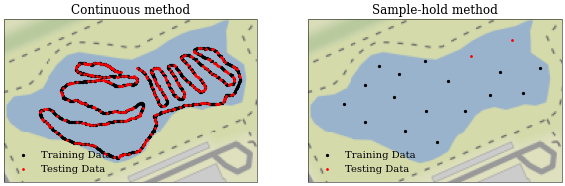

In [17]:
#quick viz of it all!
import matplotlib as mpl
%matplotlib inline

plt.style.use(['science','no-latex'])

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io.img_tiles import Stamen


location = "data/temp_cont_idw.tif"
with rio.open(location, "r") as src:
    bbox = src.bounds
    bbox = [bbox[0],bbox[2],bbox[1],bbox[3]]

train =c_train
test = c_test

tiler = Stamen('terrain')
mercator = tiler.crs


# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=1,ncols=2,
                        subplot_kw={'projection': mercator},
                        figsize = (10,10))

axs[0].set_extent(bbox, crs=ccrs.PlateCarree())
axs[0].add_image(tiler, 17)

#add train df
axs[0].scatter(train.lon, train.lat,label= "Training Data",c = "black", s = 5, transform =ccrs.PlateCarree())

axs[0].scatter(test.lon, test.lat,label= "Testing Data",c = "red", s = 3, transform =ccrs.PlateCarree())
# make two proxy artists to add to a legend
axs[0].set_title("Continuous method")
axs[0].legend(loc = 3)
#add other interpolation datset as well
train =s_train
test = s_test

axs[1].set_extent(bbox, crs=ccrs.PlateCarree())
axs[1].add_image(tiler, 17)

#add train df
axs[1].scatter(train.lon, train.lat,label= "Training Data",c = "black", s = 5, transform =ccrs.PlateCarree())

axs[1].scatter(test.lon, test.lat,label= "Testing Data",c = "red", s = 3, transform =ccrs.PlateCarree())
# make two proxy artists to add to a legend

axs[1].legend(loc = 3)
axs[1].set_title("Sample-hold method")
fig.savefig("output/test_train_split.png",dpi=200)
plt.show()

## 3.2.1 Showing the cross validation results for the best P value and train+test RMSE 
Thus explaining which interpolations where done on the final images below

<ipython-input-275-75e41e013cc2>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i,0].set_xticklabels([1,2,3,4,5,10])
<ipython-input-275-75e41e013cc2>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i,1].set_xticklabels([1,2,3,4,5,10])


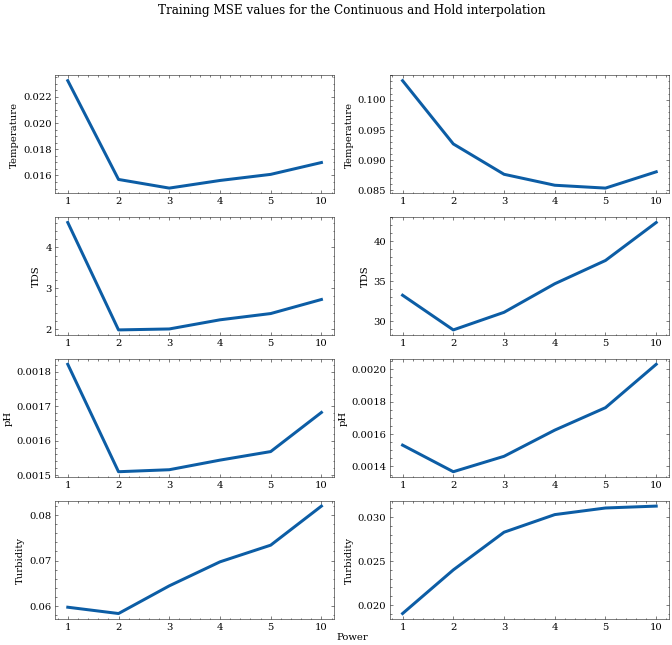

In [275]:
#quick viz of it all!
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use(['science','no-latex'])


zs  = ["temp", "tds","ph_v","t_v"]
powers = [1,2,3,4,5,10]
headers =[str(p) for p in powers]
headers = pd.Series([z + p for p in headers for z in zs])
titles = ["Temperature", "TDS", "pH", "Turbidity"]


cont = pd.read_csv("data/cv_cont_test.csv")
hold = pd.read_csv("data/cv_hold_test.csv")

fig, axs = plt.subplots(nrows = 4, ncols = 2,figsize = (11,10))
for i, item in enumerate(zs):
    sub = headers[headers.str.contains(item)]
    df = cont[sub].mean()
    axs[i,0].plot(df,linewidth = 3)
    axs[i,0].set(ylabel=titles[i])
    axs[i,0].set_xticklabels([1,2,3,4,5,10])
for i, item in enumerate(zs):
    sub = headers[headers.str.contains(item)]
    df = hold[sub].mean()
    axs[i,1].plot(df,linewidth = 3)
    axs[i,1].set(ylabel=titles[i])

    axs[i,1].set_xticklabels([1,2,3,4,5,10])
    
plt.suptitle("Training MSE values for the Continuous and Hold interpolation")
fig.text(0.5, 0.1, 'Power', va='center', ha='center', fontsize=plt.rcParams['axes.labelsize'])

plt.show()
fig.savefig("output/mse_power_interpolation.png",dpi=200)

## 3.2 Showing continuous interpolation

data/temp_cont_idw.tif saved
data/tds_cont_idw.tif saved
data/ph_v_cont_idw.tif saved
data/t_v_cont_idw.tif saved


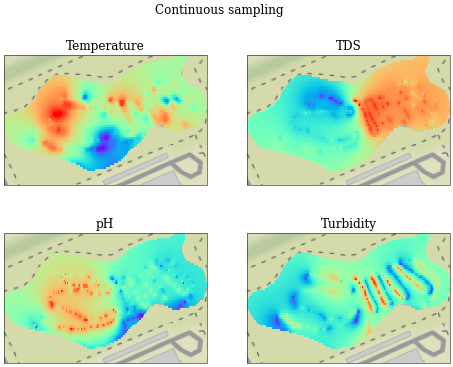

In [265]:
#quick viz of it all!
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use(['science','no-latex'])

import cartopy.crs as ccrs
from cartopy.io.img_tiles import Stamen

import xarray as xr

location = "data/temp_cont_idw_masked.tif"
with rio.open(location, "r") as src:
    bbox = src.bounds
    bbox = [bbox[0],bbox[2],bbox[1],bbox[3]]

tiler = Stamen('terrain')
mercator = tiler.crs
crs= ccrs.PlateCarree()
fig, axs = plt.subplots(nrows=2,ncols=2,
                        subplot_kw={'projection': mercator},
                       figsize = (8,6))
axs = axs.flatten()

best_p_cont = [3,2,2,2]


items = ["temp","tds", "ph_v", "t_v"]
titles = ["Temperature", "TDS", "pH", "Turbidity"]

for i, item in enumerate(items):
    
    interpolate(c_train, item, "cont", ext, f, best_p_cont[i])

    location = "data/" + item +"_cont_idw_masked.tif"

    da = xr.open_rasterio(location)
    da = da.where(da!=0)

    axs[i].set_extent(bbox, crs=crs)
    axs[i].add_image(tiler, 17)
    da.plot(ax=axs[i],transform=crs,add_colorbar= False,cmap = "rainbow")
    axs[i].set_title(titles[i])

    
plt.suptitle("Continuous sampling")
plt.show()
fig.savefig("output/continuous.png",dpi=200)

data/temp_hold_idw.tif saved
data/tds_hold_idw.tif saved
data/ph_v_hold_idw.tif saved
data/t_v_hold_idw.tif saved


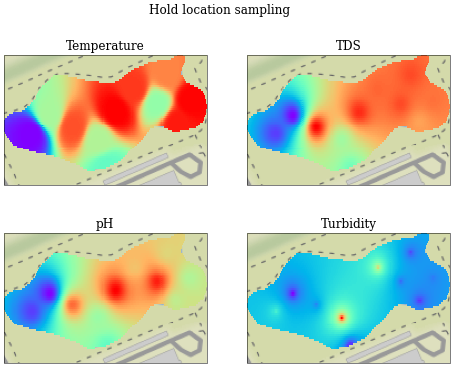

In [267]:
#quick viz of it all!
import matplotlib as mpl
%matplotlib inline

plt.style.use(['science','no-latex'])

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io.img_tiles import Stamen

import xarray as xr
location = "data/temp_cont_idw_masked.tif"
with rio.open(location, "r") as src:
    bbox = src.bounds
    bbox = [bbox[0],bbox[2],bbox[1],bbox[3]]

tiler = Stamen('terrain')
mercator = tiler.crs

best_p_hold = [5,2,2,1]
    
fig, axs = plt.subplots(nrows=2,ncols=2,
                        subplot_kw={'projection': mercator},
                       figsize= (8,6))
axs = axs.flatten()

items = ["temp","tds", "ph_v", "t_v"]
titles = ["Temperature", "TDS", "pH", "Turbidity"]
for i, item in enumerate(items):
    
    interpolate(s_train, item, "hold", ext, f, best_p_hold[i])
    location = "data/" + item +"_hold_idw_masked.tif"

    da = xr.open_rasterio(location)
    da = da.where(da!=0)

    axs[i].set_extent(bbox, crs=crs)
    axs[i].add_image(tiler, 17)
    da.plot(ax=axs[i],transform=crs,add_colorbar= False,cmap = "rainbow")
    axs[i].set_title(titles[i])
    

plt.suptitle("Hold location sampling")
plt.show()
fig.savefig("output/hold.png",dpi=200)